# Studio di Ablazione - Generalized Hough Transform (GHT)

Questo notebook implementa uno studio sistematico (ablation study) per individuare la configurazione ottimale dei parametri dell'algoritmo GHT nel contesto del rilevamento di stelle marine.

## Metodologia
L'analisi viene condotta sull'intero dataset disponibile (30 immagini), garantendo che i risultati siano rappresentativi di tutte le condizioni di illuminazione e rotazione presenti. 

Vengono testate diverse combinazioni di tre parametri fondamentali:
1.  **Votes Threshold**: La soglia minima di voti nell'accumulatore di Hough affinché un punto venga considerato un centro candidato.
2.  **Min Distance**: La distanza minima (in pixel) tra due centri rilevati per considerarli distinti.
3.  **Canny Low Threshold**: La soglia inferiore per il rilevamento dei bordi (edge detection), che influenza quali dettagli vengono considerati nel voting.

## Parametri del Test
Lo spazio di ricerca è definito dalla griglia:
*   `votes_threshold`: [3, 10, 20, 30] (4 valori)
*   `min_dist`: [15, 50, 100] (3 valori)
*   `canny_low_thresh`: [15, 50, 100] (3 valori)

Totale configurazioni testate: **36** = 4 * 3 * 3

Per ogni configurazione, vengono calcolate metriche di affidabilità (Precision, Recall, F1-Score) confrontando le predizioni con il ground truth, utilizzando una soglia di distanza di **100px** per validare i rilevamenti corretti.

In [1]:
# Import delle librerie necessarie
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import delle funzioni personalizzate da ght.py
from ght import load_dataset, run_ght_detection, evaluate_detection, calculate_metrics, ablation_study

# Configurazioni per i plot
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/home/fsoppelsa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Configurazioni globali
STANDARD_SIZE = (500, 500)  # Dimensione standard per tutte le immagini
DISTANCE_THRESHOLD = 100    # Soglia per matching con ground truth (pixel) (FIXED)
GAUSSIAN_KERNEL = (5, 5)    # Kernel per blur
GAUSSIAN_SIGMA = 1.4        # Sigma per blur
CANNY_HIGH_THRESH = 150     # Soglia alta Canny (fissa)
DP_VALUE = 2                # Parametro dp per GHT (fisso)
LEVELS_VALUE = 360          # Parametro levels per GHT (fisso)

# Percorsi dei file
DATA_DIR = Path('data/hough')
TEMPLATE_PATH = DATA_DIR / '00022_r_any_other_kind_of_starfish_169.jpg'
GT_PATH = DATA_DIR / 'ground_truth.json'
OUTPUT_CSV = 'ablation_results.csv'

print(f"Directory dati: {DATA_DIR}")

Directory dati: data/hough


In [3]:
# Import delle funzioni da ght.py e gestione dataset
from ght import load_dataset
import random

# Selezione dataset completo
available_images = list(DATA_DIR.glob('*.jpg'))
test_candidates = [img for img in available_images if TEMPLATE_PATH.name not in str(img)]

# Utilizziamo tutte le immagini disponibili per lo studio
selected_images = sorted(test_candidates)

print(f"Totale immagini nel dataset: {len(available_images)}")
print(f"Immagini utilizzate per il test (escluso template): {len(selected_images)}")

# Carica dataset e template
images, gt, template_edges, template_center = load_dataset(DATA_DIR, TEMPLATE_PATH, GT_PATH)
# Sovrascrive la lista images di load_dataset per assicurarsi che siano quelle corrette ordinate
images = selected_images

Totale immagini nel dataset: 30
Immagini utilizzate per il test (escluso template): 29
Caricamento dataset in corso...
Trovate 30 immagini valide con ground truth
Template processato. Centro: (266, 265)
Pixel di bordo nel template: 35115


In [4]:
# Import delle funzioni da ght.py
from ght import evaluate_detection, calculate_metrics

# Test delle funzioni con primo test su immagine casuale
test_eval = evaluate_detection((250, 250), (260, 255), 50)
print(f"Test valutazione: {test_eval}")

# Test detection su prima immagine selezionata casualmente
test_params = {
    'votes_threshold': 15,
    'min_dist': 50,
    'canny_low_thresh': 50
}
test_result = run_ght_detection(selected_images[0], template_edges, template_center, test_params)
print(f"Test rilevamento su immagine casuale: {test_result}")

Test valutazione: {'is_tp': True, 'distance': 11.180339887498949}
Test rilevamento su immagine casuale: {'center': (284, 272), 'confidence': 15.0, 'inference_time': 0.7948143482208252}


In [ ]:
# === STUDIO ABLAZIONE COMPLETO (Esteso) ===
from ght import run_ght_detection, evaluate_detection, calculate_metrics
from itertools import product
import numpy as np

def optimized_ablation_study(images, ground_truth, template_edges, template_center):
    """
    Esegue lo studio di ablazione esteso su tutte le combinazioni di parametri.
    Include metriche di stabilità e calcola errori di localizzazione per TP.
    """
    print("=== Inizio Studio dei Parametri (Esteso) ===")
    
    # Griglia dei parametri ampliata per osservare i limiti ("finché si rompe")
    param_grid = {
        'votes_threshold': [1, 5, 10, 20, 50, 100],  # Da molto rumoroso (1) a molto rigoroso (100)
        'min_dist': [10, 25, 50, 100],               # Da sovrapposti a molto distanziati
        'canny_low_thresh': [10, 25, 50, 100]        # Da tutto bordi a solo bordi forti
    }
    
    total_configs = len(param_grid['votes_threshold']) * len(param_grid['min_dist']) * len(param_grid['canny_low_thresh'])
    n_images = len(images)
    print(f"Configurazioni totali: {total_configs}")
    print(f"Immagini nel test set: {n_images}")
    print(f"Totale inferenze da eseguire: {total_configs * n_images}")
    
    results = []
    param_combinations = list(product(param_grid['votes_threshold'], param_grid['min_dist'], param_grid['canny_low_thresh']))
    
    for votes_th, min_d, canny_low in tqdm(param_combinations, desc="Avanzamento Test"):
        params = {'votes_threshold': votes_th, 'min_dist': min_d, 'canny_low_thresh': canny_low}
        config_results = []
        
        # Temp lists per statistiche di questa config
        tp_distances = []
        fp_count = 0
        detections_count = 0
        
        for img_path in images:
            img_name = img_path.name
            if img_name not in ground_truth: continue
            gt_center = tuple(ground_truth[img_name]['center'])
            
            # Esegui detection
            detection_result = run_ght_detection(img_path, template_edges, template_center, params)
            
            # Valuta
            evaluation = evaluate_detection(detection_result['center'], gt_center)
            
            # Logiche custom per metriche avanzate
            if detection_result['center'] is not None:
                detections_count += 1
                if evaluation['is_tp']:
                    tp_distances.append(evaluation['distance'])
                else:
                    fp_count += 1
            
            config_results.append({
                'is_tp': evaluation['is_tp'],
                'distance': evaluation['distance'],
                'inference_time': detection_result['inference_time']
            })
        
        # Metriche standard
        metrics = calculate_metrics(config_results)
        
        # Metriche avanzate
        avg_detections = detections_count / n_images
        avg_fp = fp_count / n_images
        # Errore medio SOLO sui True Positives (accuratezza localizzazione)
        avg_localization_error = np.mean(tp_distances) if tp_distances else np.nan
        
        results.append({
            'votes_threshold': votes_th, 
            'min_dist': min_d, 
            'canny_low_thresh': canny_low,
            'avg_detections': avg_detections,
            'avg_fp': avg_fp,
            'avg_localization_error': avg_localization_error,
            **metrics
        })
    
    # Ordina per F1 decrescente
    df_results = pd.DataFrame(results).sort_values('f1_score', ascending=False).reset_index(drop=True)
    
    best_res = df_results.iloc[0]
    print(f"\nStudio completato!")
    print(f"Miglior F1: {best_res['f1_score']:.3f} (V={best_res['votes_threshold']}, C={best_res['canny_low_thresh']})")
    
    return df_results

# Esegui studio sul dataset completo
# NOTA: Questa esecuzione richiederà tempo (circa 10+ minuti) a causa del numero di configurazioni
ablation_results = optimized_ablation_study(selected_images, gt, template_edges, template_center)

=== Inizio Studio dei Parametri (Esteso) ===
Configurazioni totali: 96
Immagini nel test set: 29
Totale inferenze da eseguire: 2784


Avanzamento Test: 100%|██████████| 96/96 [23:01<00:00, 14.39s/it]


Studio completato!
Miglior F1: 0.711 (V=1.0, C=10.0)


In [6]:
# === RISULTATI STUDIO OTTIMIZZATO ===
ablation_results.to_csv(OUTPUT_CSV, index=False)
print(f"Risultati salvati in: {OUTPUT_CSV}")
print("RISULTATI")

print(f"Configurazioni testate: {len(ablation_results)}")
print(f"Immagini per configurazione: {len(selected_images)}")
print(f"Test totali eseguiti: {len(ablation_results) * len(selected_images)}")

# Top 5 configurazioni
print("\nTOP 5 CONFIGURAZIONI:")
top5 = ablation_results.head(5)
for i, (_, row) in enumerate(top5.iterrows(), 1):
    print(f"{i}. V={row['votes_threshold']}, D={row['min_dist']}, C={row['canny_low_thresh']} "
          f"→ F1={row['f1_score']:.3f}, Prec={row['precision']:.3f}, Rec={row['recall']:.3f}")

# Configurazione ottimale
best_config = ablation_results.iloc[0]
print(f"\nCONFIGURAZIONE OTTIMALE:")
print(f"Votes Threshold: {best_config['votes_threshold']}")
print(f"Min Distance: {best_config['min_dist']}")
print(f"Canny Low Thresh: {best_config['canny_low_thresh']}")
print(f"Punteggio F1: {best_config['f1_score']:.4f}")
print(f"Precisione: {best_config['precision']:.4f}")
print(f"Richiamo: {best_config['recall']:.4f}")
print(f"Tempo medio: {best_config['mean_inference_time']*1000:.1f} ms")

# Confronto con benchmark
benchmark_in_results = ablation_results[
    (ablation_results['votes_threshold'] == 15) & 
    (ablation_results['min_dist'] == 50) & 
    (ablation_results['canny_low_thresh'] == 50)
]
if not benchmark_in_results.empty:
    bench_f1 = benchmark_in_results['f1_score'].iloc[0]
    print(f"\nConfigurazione benchmark (15,50,50): F1={bench_f1:.3f}")
    print(f"Miglioramento: {((best_config['f1_score'] - bench_f1) / bench_f1 * 100):+.1f}%")

print(f"\nDISTRIBUZIONE PERFORMANCE:")
print(f"F1 medio: {ablation_results['f1_score'].mean():.4f}")
print(f"Configurazioni con F1 > 0.3: {(ablation_results['f1_score'] > 0.3).sum()}")
print(f"Configurazioni con F1 > 0.5: {(ablation_results['f1_score'] > 0.5).sum()}")
print(f"Configurazioni con F1 > 0.7: {(ablation_results['f1_score'] > 0.7).sum()}")

Risultati salvati in: ablation_results.csv
RISULTATI
Configurazioni testate: 96
Immagini per configurazione: 29
Test totali eseguiti: 2784

TOP 5 CONFIGURAZIONI:
1. V=1.0, D=10.0, C=10.0 → F1=0.711, Prec=0.552, Rec=1.000
2. V=20.0, D=100.0, C=10.0 → F1=0.711, Prec=0.552, Rec=1.000
3. V=5.0, D=100.0, C=10.0 → F1=0.711, Prec=0.552, Rec=1.000
4. V=10.0, D=10.0, C=10.0 → F1=0.711, Prec=0.552, Rec=1.000
5. V=10.0, D=25.0, C=10.0 → F1=0.711, Prec=0.552, Rec=1.000

CONFIGURAZIONE OTTIMALE:
Votes Threshold: 1.0
Min Distance: 10.0
Canny Low Thresh: 10.0
Punteggio F1: 0.7111
Precisione: 0.5517
Richiamo: 1.0000
Tempo medio: 564.8 ms

DISTRIBUZIONE PERFORMANCE:
F1 medio: 0.6801
Configurazioni con F1 > 0.3: 96
Configurazioni con F1 > 0.5: 96
Configurazioni con F1 > 0.7: 24


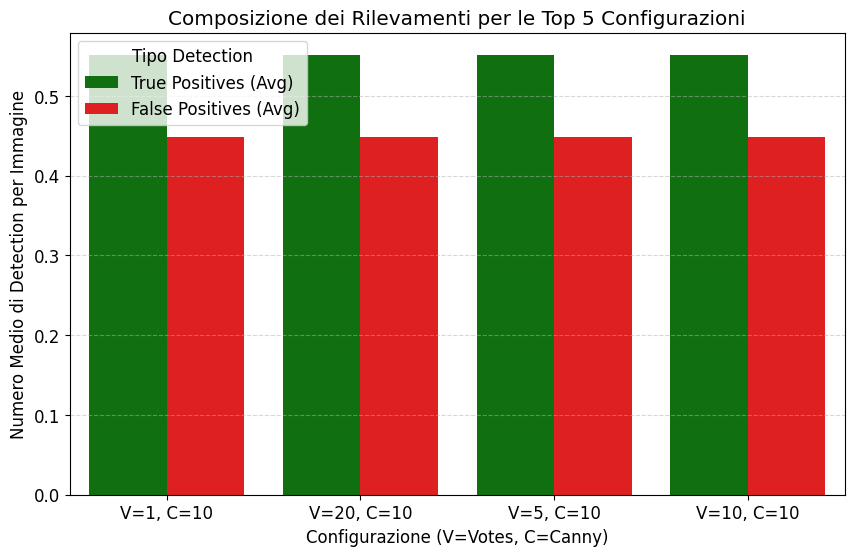

Tabella TOP 5 Configurazioni (Dettagli):
 votes_threshold  min_dist  canny_low_thresh  f1_score  avg_true_positives  avg_false_positives
               1        10                10  0.711111            0.551724             0.448276
              20       100                10  0.711111            0.551724             0.448276
               5       100                10  0.711111            0.551724             0.448276
              10        10                10  0.711111            0.551724             0.448276
              10        25                10  0.711111            0.551724             0.448276


In [10]:
# === VISUALIZZAZIONE RISULTATI ESTESA ===

# 1. Grafico Conteggio Rilevamenti Top 5 
# Mostriamo Quante detection totali (TP + FP) vengono fatte dalle configurazioni "migliori"
# per capire se alcune sono "troppo" aggressive o meno
top5 = ablation_results.head(5).copy()
top5['config_label'] = top5.apply(lambda x: f"V={int(x['votes_threshold'])}, C={int(x['canny_low_thresh'])}", axis=1)

# Prepara i dati per un grafico a barre raggruppato o stacked se avessimo TP/FP separati
# Ma qui abbiamo avg_detections e avg_fp.
# Poiché avg_detections = avg_tp + avg_fp, possiamo visualizzare questo composition
# avg_tp = avg_detections - avg_fp

top5['avg_tp'] = top5['avg_detections'] - top5['avg_fp']

plt.figure(figsize=(10, 6))

# Creiamo un DataFrame "sciolto" per usare seaborn barplot con hue
plot_data = []
for _, row in top5.iterrows():
    plot_data.append({
        'Config': row['config_label'],
        'Type': 'True Positives (Avg)',
        'Count': row['avg_tp']
    })
    plot_data.append({
        'Config': row['config_label'],
        'Type': 'False Positives (Avg)',
        'Count': row['avg_fp']
    })

df_plot = pd.DataFrame(plot_data)

sns.barplot(x='Config', y='Count', hue='Type', data=df_plot, palette={'True Positives (Avg)': 'green', 'False Positives (Avg)': 'red'})

plt.title('Composizione dei Rilevamenti per le Top 5 Configurazioni')
plt.ylabel('Numero Medio di Detection per Immagine')
plt.xlabel('Configurazione (V=Votes, C=Canny)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Tipo Detection')
plt.show()

print("Tabella TOP 5 Configurazioni (Dettagli):")
# Aggiorniamo le colonne visualizzate per riflettere il grafico (TP e FP medi)
display_cols = ['votes_threshold', 'min_dist', 'canny_low_thresh', 'f1_score', 'avg_tp', 'avg_fp']
# Rinominiamo le colonne per chiarezza nella visualizzazione
top5_display = top5[display_cols].rename(columns={
    'avg_tp': 'avg_true_positives', 
    'avg_fp': 'avg_false_positives'
})
print(top5_display.to_string(index=False))